# ✨Learning objectives
- Learn how to work with pretrained deep learning models using the `pytorch` framework
- Learn how to train a powerful image classification model using a combination of image embeddings and logistic regression
- Learn how to save and load a trained model for further integration into software applications

# Business problem:

Given an image dataset manually sorted into multiple classes, can we train an accurate image classification model?
Additionally, due to constraints on resources and time, we need to do it quickly and without access to powerful computational hardware (e.g. GPUs).

# Our approach

The approach we are taking in this notebook is summarized in the diagram below.
Don't worry if it's not clear right away. 

Once you've worked your way through the entire notebook, please return to this diagram to see if you can identify which parts of the notebook correspond to which stage in the diagram.

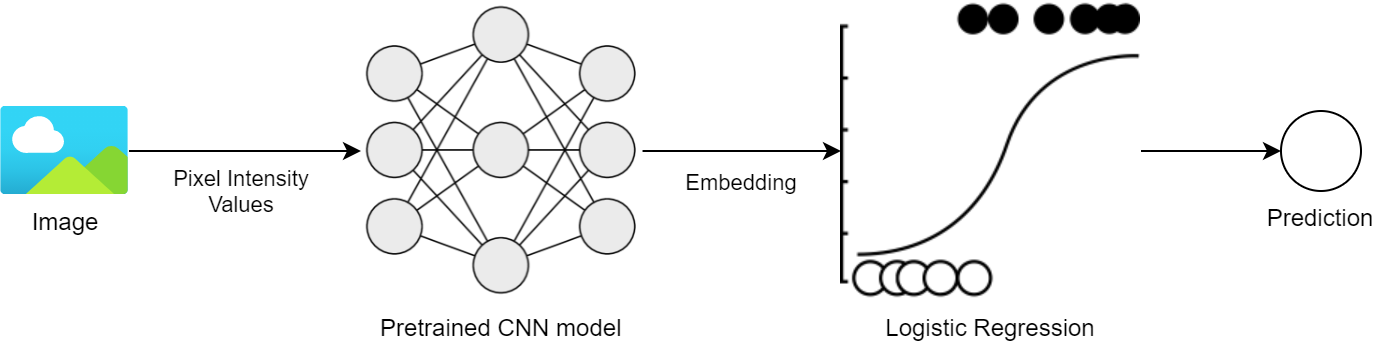


### Description of the dataset
- Source of the dataset: https://figshare.com/articles/dataset/POLEN23E/1525086
- This dataset of pollen grain images was first introduced in 2016: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0157044
> The classification of pollen species and types is an important task in many areas like forensic palynology, archaeological palynology and melissopalynology. This paper presents the first annotated image dataset for the Brazilian Savannah pollen types that can be used to train and test computer vision based automatic pollen classifiers. A first baseline human and computer performance for this dataset has been established using 805 pollen images of 23 pollen types.

### Download and extract the dataset

In [1]:
import urllib.request
import zipfile

from pathlib import Path

In [2]:
# setup target filenames and directories
data_archive_url = 'https://ndownloader.figshare.com/articles/1525086/versionsa/1'
data_path = Path('data')
if not data_path.exists():
    data_path.mkdir(exist_ok=True)
downloaded_zip_path = data_path/'POLEN23E.zip'
extracted_path = data_path/'POLEN23E'

In [3]:
# download and unzip the data
if not downloaded_zip_path.exists():
    urllib.request.urlretrieve(data_archive_url, downloaded_zip_path)
    with zipfile.ZipFile(downloaded_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

In [4]:
# read all image filenames into a list
img_flist = list(extracted_path.glob('*.jpg'))
len(img_flist)

790

There are 790 unique images. Let's take a look at a few of them

### Review the images

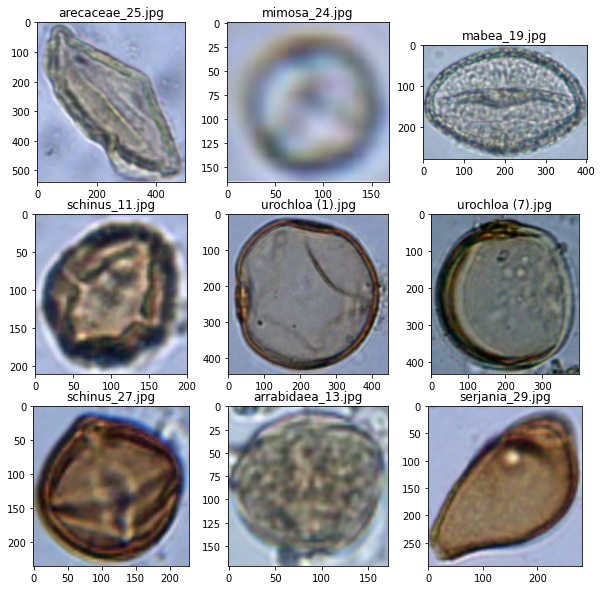

In [5]:
import matplotlib.pyplot as plt
from random import sample
from PIL import Image

fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    sample_img_path = sample(img_flist, 1)[0]
    img = Image.open(sample_img_path)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(sample_img_path.name)
plt.show()

We can see that the labels can be extracted from the filenames by splitting the filename string by an underscore `_`.

However, upon closer inspection, you'll notice that some filenames need to be split by spaces rather than underscores.

In [6]:
# first five filenames
img_flist[:5]

[PosixPath('data/POLEN23E/anadenanthera_16.jpg'),
 PosixPath('data/POLEN23E/anadenanthera_17.jpg'),
 PosixPath('data/POLEN23E/anadenanthera_18.jpg'),
 PosixPath('data/POLEN23E/anadenanthera_19.jpg'),
 PosixPath('data/POLEN23E/anadenanthera_20.jpg')]

In [7]:
# last five filenames
img_flist[-5:]

[PosixPath('data/POLEN23E/urochloa (5).jpg'),
 PosixPath('data/POLEN23E/urochloa (6).jpg'),
 PosixPath('data/POLEN23E/urochloa (7).jpg'),
 PosixPath('data/POLEN23E/urochloa (8).jpg'),
 PosixPath('data/POLEN23E/urochloa (9).jpg')]

To split the filenames by either a space or an underscore, we'll use python's built-in regex library `re`.

In [8]:
import re

In [9]:
print(img_flist[0].name)
print(re.split('_| ', img_flist[0].name))

anadenanthera_16.jpg
['anadenanthera', '16.jpg']


In [10]:
print(img_flist[-1].name)
print(re.split('_| ', img_flist[-1].name))

urochloa (9).jpg
['urochloa', '(9).jpg']


We'll reuse this line of code (`re.split('_| ', <filename>`) later. For now, keep it mind.

# Load a pretrained Convolutional Neural Network (CNN) model

In [11]:
import torch
import torchvision
import torchvision.models as models

`torchvision` is a library that compliments `pytorch` with computer vision tools and models.

In the following two cells, we'll:
1. load a pretrained [ResNet](https://arxiv.org/abs/1512.03385) model.
There are [several variations](https://pytorch.org/hub/pytorch_vision_resnet/) of the ResNet architecture available in `torchvision`: `resnet18`, `resnet34`, ..., `resnet152`.
The number indicates how many layers are in its architecture. A general rule of thumb:
```
more layers --> more potential to learn complex patterns in the data --> more training data is needed to take advantage of this potential
```
2. define transformations that we need to apply to each image so that the input to the model has the same properties as the images that this model was trained on. Specifically, we'll define the following transformations:
   - resize each image to 256x256
   - take a square crop from the center the size of 224x224
   - convert each image to a pytorch tensor
   - scale pixel intensities to have some predefined mean and standard deviation (calculated based on a large image dataset known as [ImageNet](https://www.image-net.org/)). See [pytorch documentation](https://pytorch.org/vision/stable/models.html) for further explanation
   > All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [12]:
pretrained_model = models.resnet18(pretrained=True)
pretrained_model = pretrained_model.eval()

In [13]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Extract image embeddings

Finally, we'll write a function that takes an image and returns its vector representation (also known as an embedding) from our pretrained model.
Here's what this function does:
1. Applies the above transformations to the input image
(also, `.unsqueeze(dim=0)` creates a batch of one image because the model expects batches of images as inputs)
2. Creates a "reduced" version of the pretrained model by ignoring the very last layer of the network
(`list(pretrained_model.children())[:-1]`). The layer before the last one will output the vectors (image features) we are interested in. 
3. Converts the output from pytorch tensor to numpy array

In [14]:
def get_img_vec(img):
    img = transforms(img).unsqueeze(dim=0)
    feature_extractor = torch.nn.Sequential(*list(pretrained_model.children())[:-1])
    output = feature_extractor(img)
    output = torch.squeeze(output).detach().numpy()
    return output

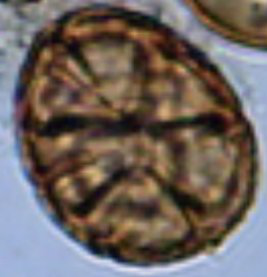

In [15]:
# get a sample image
img_path = img_flist[0]
img = Image.open(img_path)
img

In [16]:
# get the embedding
vec = get_img_vec(img)
vec

/home/akim/.local/share/virtualenvs/cv_webinars-0oJbYyW7/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


array([1.33987486e+00, 3.28596920e-01, 1.29234576e+00, 1.13392723e+00,
       5.44513226e-01, 3.92153651e-01, 2.50972772e+00, 1.10941601e+00,
       9.20267463e-01, 3.54974836e-01, 1.04896748e+00, 1.24780750e+00,
       1.15157887e-01, 4.40945297e-01, 3.25678051e-01, 1.00617528e+00,
       3.48156750e-01, 2.24555635e+00, 2.55702043e+00, 2.42115095e-01,
       3.44480395e-01, 0.00000000e+00, 7.60629714e-01, 2.98174500e-01,
       2.93729568e+00, 7.60600507e-01, 9.20251727e-01, 1.35323238e+00,
       2.29804173e-01, 3.11225392e-02, 4.08197939e-01, 1.34122819e-01,
       5.92228591e-01, 1.29026794e+00, 7.61944234e-01, 3.99228744e-02,
       2.53273118e-02, 3.35503936e-01, 7.41850793e-01, 1.13474107e+00,
       1.99159861e-01, 3.01002413e-01, 7.63975203e-01, 6.68523729e-01,
       5.35980202e-02, 1.52912343e+00, 5.55355012e-01, 4.21896845e-01,
       3.40019524e-01, 4.81955004e+00, 4.28757489e-01, 8.94482583e-02,
       4.17435944e-01, 4.20010742e-03, 2.01167846e+00, 2.95627087e-01,
      

In [17]:
vec.shape

(512,)

As we can see `resnet18` model will output 512-dimensional embeddings.
Other models might have embeddings with different dimensionality.
However, it's very common for the embeddings to have sizes that represent the powers of 2, e.g. 512, 1024 and 2048.

Now let's transform our image dataset into a `pd.DataFrame` containing embeddings (`X`) and a  `pd.Series` containing labels

In [18]:
import pandas as pd
from tqdm.auto import tqdm

X = []
y = []

for img_fpath in tqdm(img_flist):
    img = Image.open(img_fpath)
    vec = get_img_vec(img)
    label = re.split('_| ', img_fpath.name)[0]
    X.append(vec)
    y.append(label)

X = pd.DataFrame(X)
y = pd.Series(y)

  0%|          | 0/790 [00:00<?, ?it/s]

In [19]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,1.339875,0.328597,1.292346,1.133927,0.544513,0.392154,2.509728,1.109416,0.920267,0.354975,...,0.217648,0.625341,2.253731,0.012568,0.766533,1.011089,0.338930,0.711118,0.608330,0.613997
1,0.201643,0.419185,0.500751,1.716043,0.019110,0.643496,1.256870,0.339626,1.825647,0.839047,...,0.531199,0.694212,0.911593,0.024255,0.348792,0.339363,0.362118,0.285629,0.444145,0.539838
2,0.758076,0.241719,0.814049,0.832038,0.162181,0.161663,2.295728,0.428957,0.536558,0.490910,...,0.709063,0.898288,1.654396,0.172455,0.465595,2.240495,0.727283,0.493300,0.329039,1.691645
3,1.244469,0.330813,0.385278,0.732811,0.335211,0.106365,2.280755,0.845070,0.824438,0.516464,...,1.270090,0.029812,3.647389,0.056576,1.105083,1.603186,0.453577,1.119995,0.122851,1.010983
4,2.416623,0.412816,0.267597,1.255969,0.576244,0.677116,1.742566,1.428448,1.308033,0.852485,...,0.354374,0.000000,4.427204,0.101068,0.346264,0.828888,0.599236,0.074258,0.279466,2.488668


In [20]:
y.head()

0    anadenanthera
1    anadenanthera
2    anadenanthera
3    anadenanthera
4    anadenanthera
dtype: object

In [21]:
y.value_counts()

mabea            35
matayba          35
tridax           35
syagrus          35
serjania         35
senegalia        35
schinus          35
qualea           35
protium          35
myrcia           35
mimosa           35
urochloa         35
arecaceae        35
hyptis           35
faramea          35
eucalipto        35
dipteryx         35
croton           35
combretum        35
chromolaena      35
cecropia         35
arrabidaea       35
anadenanthera    20
dtype: int64

It looks like we have a reasonably well-balanced distribution of labels.

Let's split out data into train and test sets.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    stratify=y,
                                                    random_state=42)

In [23]:
y_train.value_counts()

matayba          24
arrabidaea       24
croton           24
qualea           24
arecaceae        24
myrcia           24
faramea          24
chromolaena      24
tridax           24
combretum        24
dipteryx         23
hyptis           23
urochloa         23
mimosa           23
senegalia        23
schinus          23
protium          23
mabea            23
eucalipto        23
syagrus          23
cecropia         23
serjania         23
anadenanthera    13
dtype: int64

In [24]:
y_test.value_counts()

protium          12
eucalipto        12
schinus          12
senegalia        12
dipteryx         12
mabea            12
serjania         12
urochloa         12
cecropia         12
syagrus          12
hyptis           12
mimosa           12
tridax           11
arecaceae        11
combretum        11
chromolaena      11
qualea           11
matayba          11
myrcia           11
arrabidaea       11
croton           11
faramea          11
anadenanthera     7
dtype: int64

### Let's see where we are at
So far, we have:
1. explored the dataset
2. exported a pretrained CNN model and defined image transformations
3. mapped all images to their vectors representations
4. split the dataset into train and test set

Next, we'll:
1. train a `LogisticRegression` model from `sklearn`
2. compute two metrics: accuracy and f1-score
3. visualize confusion matrix

In [25]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [26]:
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'accuracy:  {acc:.2f}')
print(f'f1_score: {f1:.2f}')

accuracy:  0.92
f1_score: 0.92


92% accuracy is not bad at all! 

It is especially impressive considering the state-of-the-art result just a couple of years ago was around 97%:
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0201807
> The three methods make use of convolutional neural networks: the first one is strictly based on the idea of transfer learning, the second one is based on feature extraction and the third one represents a hybrid approach, combining transfer learning and feature extraction. The results from the three methods are indeed very good, reaching over 97% correct classification rates in images not previously seen by the models, where other authors reported around 70.

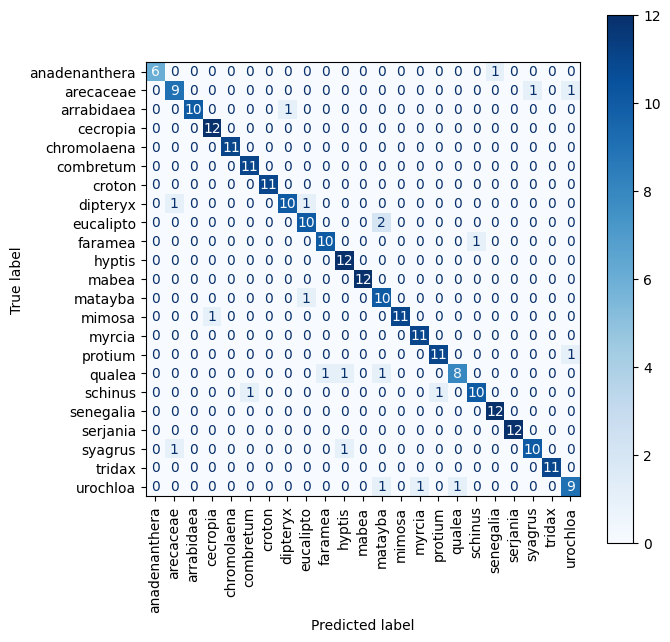

In [27]:
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams['figure.dpi'] = 100

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical', cmap='Blues')  
plt.show() 

After visualizing the" confusion matrix, we can see our model making some occasional mistakes.

The most commonly confused classes are `eucalipto` and `matayba`.

Let's looks at a few images from both classes.

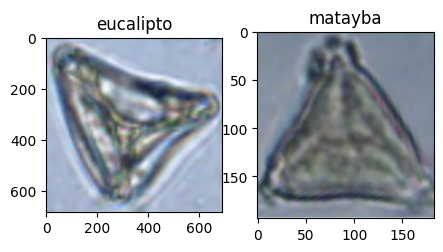

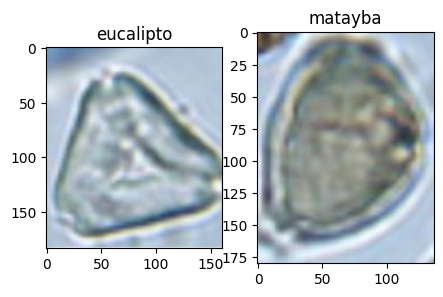

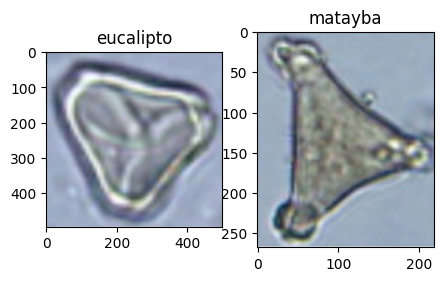

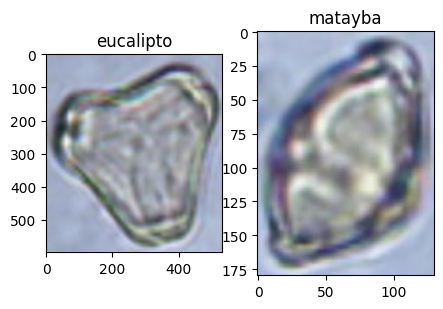

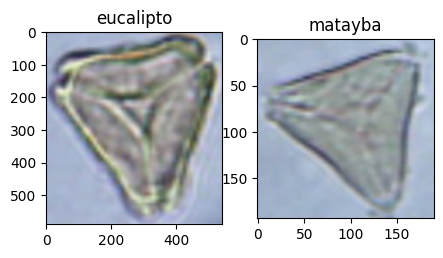

In [28]:
all_eucalipto_images = [img_path for img_path in img_flist if 'eucalipto' in img_path.name]
all_matayba_images = [img_path for img_path in img_flist if 'matayba' in img_path.name]
sample_eucalipto_images = sample(all_eucalipto_images, 5)
sample_matayba_images = sample(all_matayba_images, 5)

for eucalipto_img_path, mataybao_img_path in list(zip(sample_eucalipto_images, sample_matayba_images)):
    fig = plt.figure(figsize=(5, 5))
    fig.add_subplot(1,2,1)
    plt.imshow(Image.open(eucalipto_img_path))
    plt.title('eucalipto')
    fig.add_subplot(1,2,2)
    plt.imshow(Image.open(mataybao_img_path))
    plt.title('matayba')

They are indeed very similar!

# Put it all together

Say we want to add this prediction functionality as a part of a bigger application (web or mobile).

Which parts of the code will we need for the model to work outside of this notebook?

First, we'll need to save (aka serialize) our model.

In [29]:
from joblib import dump

dump(clf, 'classifier_model.joblib') 

['classifier_model.joblib']

Once the model is saved into a file on disk, we can move to someplace that's easily accessible by the application code.
Inside the application,| we'll need to:
1. copy the code that defines: `pretrained_model`, `transforms` and `get_img_vec`
2. load the `clf` classifier from the saved model file

In [30]:
from joblib import load

clf = load('classifier_model.joblib') 

The code below illustrates how to get a model's prediction from a sample image

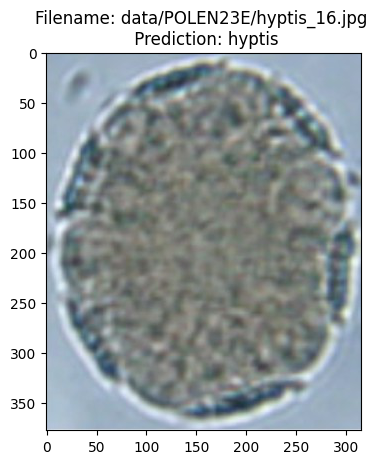

In [31]:
sample_img_path = sample(img_flist, 1)[0]
img = Image.open(sample_img_path)

vec = get_img_vec(img)
pred = clf.predict([vec])[0]

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title(f'Filename: {sample_img_path} \n Prediction: {pred}');

# ✔️Summary

- you don't need to train a CNN model from scratch to have a powerful image classification model if you take advantage of pretrained models
- `pytorch` comes with many pretrained computer vision models (same applies to `tensorflow`/`keras`)
- pretrained models extract latent features from images that are so powerful that even a simple Logistic Regression model achieves excellent performance
- most of the code needed to train a model is not needed for inference (i.e. when a model is used for prediction as part of a bigger application)

# ☝️Where to go from here?

- If you are already familiar with the `keras` framework, try replicating these results in `keras`. Take a look at [this example](https://keras.io/api/applications/#extract-features-from-an-arbitrary-intermediate-layer-with-vgg19) that uses VGG19 architecture
- Try the same approach on a different dataset. How about classifying [butterfly species](https://www.kaggle.com/gpiosenka/butterfly-images40-species)? 

# 📓 Additional resources:

- [Transfer Learning in Keras with Computer Vision Models](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/)
- [Finetuning Torchvision Models](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
